In [1]:
import sys
curr_dir = '/user_data/vayzenbe/GitHub_Repos/kornet'
curr_dir = 'C:/Users/vayze/Documents/Research/Projects/HemiSpace/behavior/data'


#add curr_dir to path
sys.path.insert(1, curr_dir)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from glob import glob as glob

In [7]:
data_dir = f'{curr_dir}/kornet/data'
results_dir = f'{curr_dir}/results'
fig_dir = f'{curr_dir}/figures'



conds = [0, 'complete', 'perturbed','deleted']
durations = [.3,.25, .2,.15,.1]
speed = ['intro','slow','slow','fast','fast']


data_files = glob(f'{data_dir}/*.csv')

In [8]:


sub_summary = pd.DataFrame(columns = ['sub','cond','duration','acc','rt'])

for sub_file in data_files:


    #check if subfile is not empty
    if len(sub_file) != 0:
        
    
        temp_summary = pd.DataFrame(columns = sub_summary.columns)
        #glob a file from cond with sub number
        

        #load sub data
        sub_data = pd.read_csv(sub_file)

        #remove practice trials
        sub_data = sub_data[sub_data['pracTrials.ran']!=1]
        acc = sub_data.groupby(['Duration']).mean()
        sem = sub_data.groupby(['Duration']).sem()
        

        #extract rt data where corr is 1
        rt = sub_data[sub_data['resp.corr']==1].groupby(['Duration']).mean()

        temp_summary['acc'] = acc['resp.corr']
        temp_summary['rt'] = rt['resp.rt']
        temp_summary['duration']= acc.index
        temp_summary['sub'] = sub_data['participant'].values.tolist()[0]
        temp_summary['cond'] = sub_data['condition'].values.tolist()[0]
        #temp_summary['age'] = sub_info[sub_info['sub']==sub]['age'].values[0]
        #temp_summary['sex'] = sub_info[sub_info['sub']==sub]['sex'].values[0]

        #check if acc for .3 duration is over .5
        #if temp_summary[temp_summary['duration']==.3]['acc'].values[0] > .5:
        sub_summary = pd.concat([sub_summary, temp_summary], axis = 0)

    else:
        print(f'no file for {sub_file}')


#append column for speed
for i in range(len(durations)):
    sub_summary.loc[sub_summary['duration']==durations[i],'speed'] = speed[i]



In [9]:
sub_summary.groupby(['sub', 'cond']).mean()

,,duration,acc,rt
sub,cond,,,
5bc6299e8b25de0001d909f8,1.0,0.2,0.960000,0.821865
5bcae4e85c2b810001dc2466,2.0,0.2,0.989474,0.553003
5c3f1d6522d8d800015b6e58,1.0,0.2,1.000000,0.707282
5c76474e3348af00159191e4,3.0,0.2,1.000000,0.840125
5cd0b82bae977b00015d30eb,2.0,0.2,1.000000,0.696341
5d07fc124e753800168ccafe,1.0,0.2,0.938889,0.740803
5d0aa9aa5047d20018b8490d,2.0,0.2,0.989474,0.717091
5ea9fdf797d3bc1683662ad4,1.0,0.2,1.000000,0.634935
5eee22ab319d6928d2ec1030,1.0,0.2,1.000000,0.962457


In [16]:
sub_data['participant'].values.tolist()[0]

'5bc6299e8b25de0001d909f8'

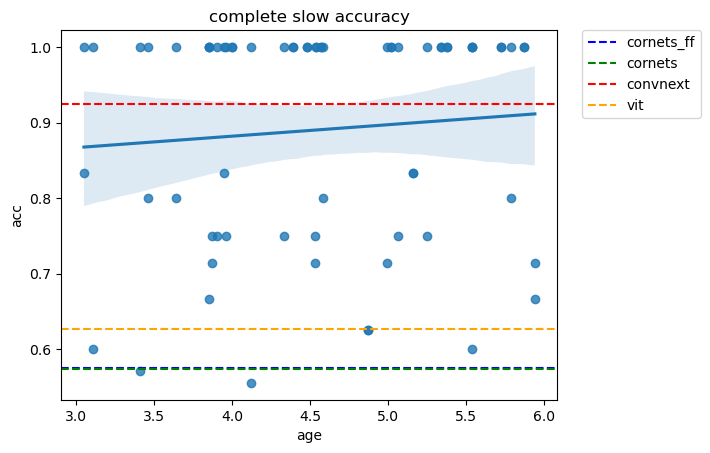

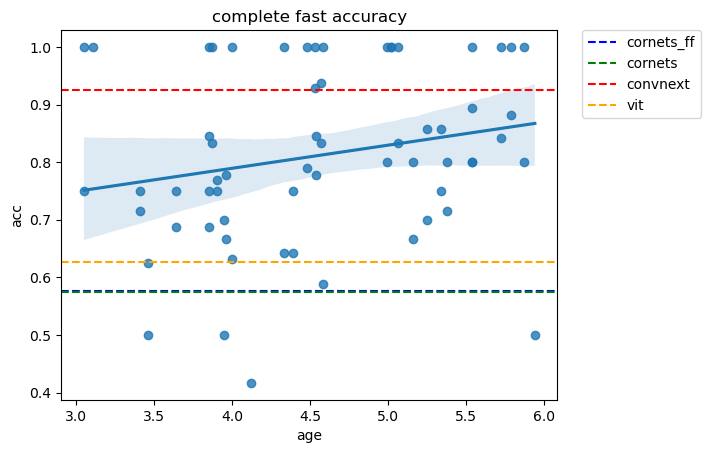

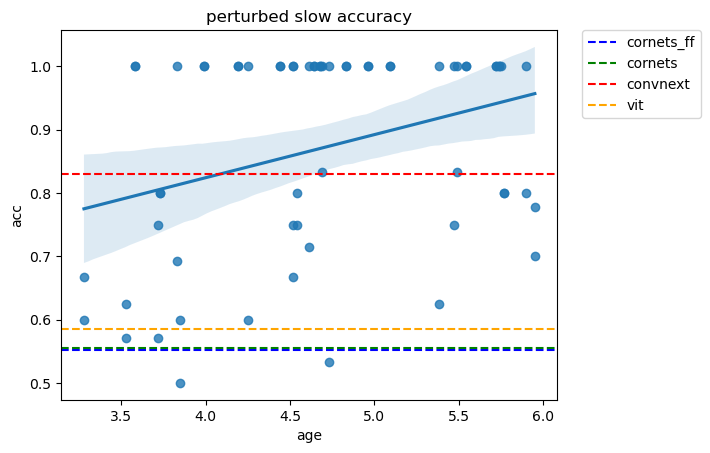

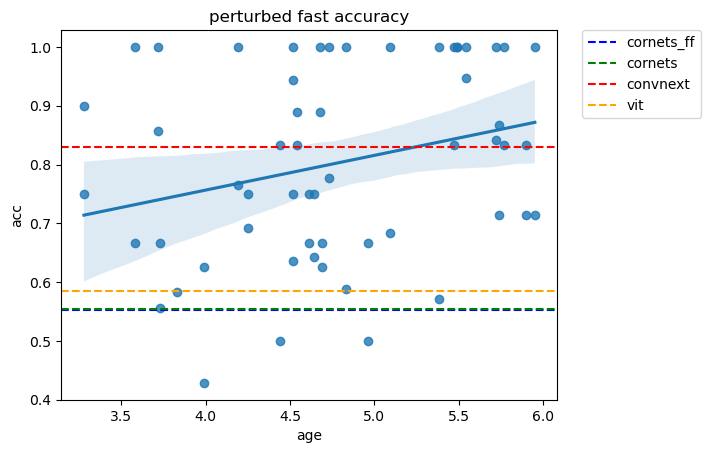

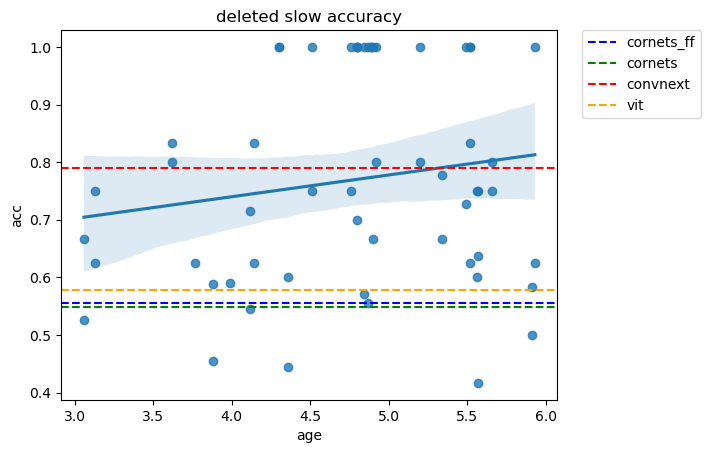

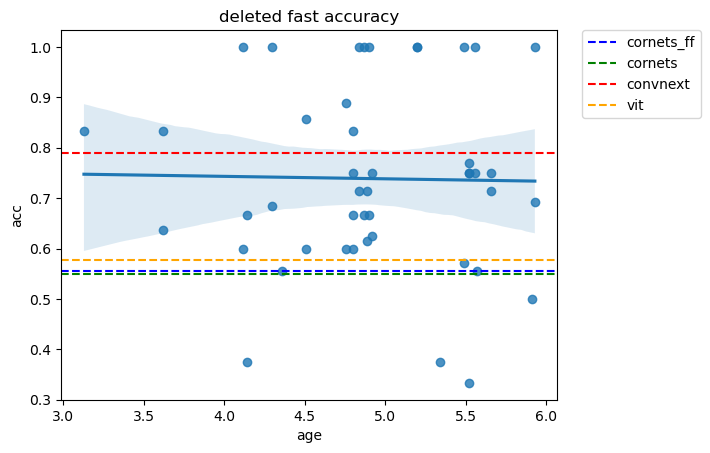

In [63]:
speeds = ['slow','fast']
conds = ['complete','perturbed','deleted']
model_conds = ['Outline','Pert','IC']
sub_summary['age'] = sub_summary['age'].astype(float)
sub_summary['acc'] = sub_summary['acc'].astype(float)

colors = ['b','g','r','orange']



#plot accuracy as a function of speed and condition
for cond in conds:
    for speed in speeds:
        plt.figure()
        #sns.scatterplot(x = 'age', y = 'acc', data = sub_summary[(sub_summary['cond']==cond) & (sub_summary['speed']==speed)])
        ax = sns.regplot(x = 'age', y = 'acc', data = sub_summary[(sub_summary['cond']==cond) & (sub_summary['speed']==speed)])
        plt.title(f'{cond} {speed} accuracy')
        #plt.savefig(f'{results_dir}/{cond}_{speed}_acc.png')
        n = 0
        #load model data in seperate colors as Y-intercept
        for model in models:
            model_data = pd.read_csv(f'{results_dir}/{model}_{model_conds[conds.index(cond)]}_summary.csv')
            model_acc = model_data['acc'].mean()

            #plote model data as a horizontal line
            plt.axhline(y = model_acc, color = colors[n], linestyle = '--',label = model)

            
            n+=1

        handles, _ = ax.get_legend_handles_labels()
        plt.legend(handles = handles[0:],labels = models,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        #place legend outside of graph
        plt.savefig(f'{fig_dir}/{cond}_{speed}_acc.png', bbox_inches='tight')
        plt.show()
        

In [25]:
rt

,resp.corr,resp.rt,pracTrials.thisRepN,pracTrials.thisTrialN,pracTrials.thisN,pracTrials.thisIndex,pracTrials.ran,participant,frameRate,trials.thisRepN,trials.thisTrialN,trials.thisN,trials.thisIndex,trials.ran,objNum
Duration,,,,,,,,,,,,,,,
0.10,1.0,7.779913,NaN,NaN,NaN,NaN,NaN,6001.0,60.0,0.0,22.666667,22.666667,11.916667,1.0,19.416667
0.15,1.0,6.317155,NaN,NaN,NaN,NaN,NaN,6001.0,60.0,0.0,11.500000,11.500000,14.833333,1.0,24.833333
0.20,1.0,3.647547,NaN,NaN,NaN,NaN,NaN,6001.0,60.0,0.0,6.000000,6.000000,18.000000,1.0,28.666667
0.25,1.0,6.800162,NaN,NaN,NaN,NaN,NaN,6001.0,60.0,0.0,3.000000,3.000000,12.333333,1.0,19.333333
0.30,1.0,3.573078,NaN,NaN,NaN,NaN,NaN,6001.0,60.0,0.0,0.500000,0.500000,13.500000,1.0,23.000000
